In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

import graphviz

from sklearn.metrics import accuracy_score

## Decision Tree


#### **Building Decision Tree**

##### Split Dataset Based on Feature and Threshold

In [10]:
def split_dataset(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = X[:, feature_index] > threshold
    return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

- `feature_index`: `X`의 어떤 feature(열)을 기준으로 data를 분할할 것인지 나타내는 index

최적의 분할을 찾아야 함!
임의의 threshold에 대해 분할한 후, entropy 및 gini index 계산, 점수가 더 낮아지는지 높아지는지 확인하여 threshold 갱신.

In [11]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

In [12]:
def gini_index(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum([p ** 2 for p in probabilities])

In [13]:
def best_split(X, y, criterion='gini'):
    best_score = float('inf') # 초기 점수 설정
    best_feature = None # 최적의 feature index 초기화
    best_threshold = None # 최적의 threshold 초기화
    
    for feature_index in range(X.shape[1]): # 모든 feature에 대해 분할 시도
        
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds: # 해당 feature 내 모든 고유한 값들에 대해 분할 시도
            X_left, y_left, X_right, y_right = split_dataset(X, y, feature_index, threshold)
            
            if len(y_left)==0 or len(y_right)==0: # 유효하지 않은 분할은 건너뜀
                continue
            
            # 분할된 노드에 대해 불순도 계산
            if criterion == 'gini':
                score = (len(y_left) * gini_index(y_left) + len(y_right) * gini_index(y_right)) / len(y)
            elif criterion == 'entropy':
                score = (len(y_left) * entropy(y_left) + len(y_right) * entropy(y_right)) / len(y)
            
            # 갱신
            if score < best_score:
                best_score = score
                best_feature = feature_index
                best_threshold = threshold
    
    return best_feature, best_threshold

##### Defining Tree Node

In [14]:
# decision tree의 노드 정의
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature # 분할에 사용된 feature index
        self.threshold = threshold # 분할에 사용된 threshold
        self.left = left   # 좌측 자식 노드
        self.right = right # 우측 자식 노드
        self.value = value # 리프 노드에 저장되는 클래스 값, 분류 문제에서는 이 값이 최종 예측 클래스가 됨

In [15]:
# decision tree를 생성하는 함수
def build_tree(X, y, depth=0, max_depth=None, criterion='gini'):
    
    # 종료 조건:
    ## 현재 노드에 있는 데이터가 모두 같은 클래스로 분류된다면
    ## 최대 깊이에 도달했다면
    ### 현재 노드를 리프 노드로 설정하고, 가장 빈도가 높은 클래스를 `value`로 설정함
    if len(np.unique(y)) == 1 or (max_depth is not None and depth >= max_depth):
        return DecisionTreeNode(value=np.bincount(y).argmax())
    
    # 최적 분할
    feature, threshold = best_split(X, y, criterion=criterion)
    ## 만약 `feature`가 `None`으로 반환되면, 
    ## 이는 더 이상 분할할 의미가 없다는 것을 뜻하므로, 현재 노드를 리프 노드로 설정함
    if feature is None:
        return DecisionTreeNode(value=np.bincount(y).argmax())
    
    # dataset 분할
    X_left, y_left, X_right, y_right = split_dataset(X, y, feature, threshold)
    
    # left 자식 노드 생성
    left_child = build_tree(X_left, y_left, depth+1, max_depth, criterion)
    # right 자식 노드 생성
    right_child = build_tree(X_right, y_right, depth+1, max_depth, criterion)
    
    return DecisionTreeNode(feature=feature, threshold=threshold, left=left_child, right=right_child)

- decision tree은 binary tree 구조!
    - 각 노드에 저장된 데이터를 특정 기준에 따라 두 개의 하위 집합으로 나누고, 두 하위 집합을 left/right 자식 노드로 전달함
    - 일반적으로 분할 기준을 만족하는(threshold보다 작거나 같은) 데이터가 left 자식 노드로 전달되고, 분할 기준을 만족하지 않는(threshold보다 큰) 데이터가 right 자식 노드로 전달됨

##### Predict Using Decision Tree

In [16]:
def predict(tree, X):
    # 현재 노드가 리프 노드인지 확인
    ## `tree.value`가 `None`이 아니라면, 리프 노드임을 의미함!
    ## 리프 노드일 경우 해당 값을 바로 반환함
    if tree.value is not None:
        return tree.value
    
    # 현재 노드의 분할 기준에 따라 다음 노드를 선택
    feature_val = X[tree.feature]
    if feature_val <= tree.threshold:
        return predict(tree.left, X) # left 자식 노드로 이동
    else:
        return predict(tree.right, X) # right 자식 노드로 이동

e.g.
- 주어진 데이터 포인트 `X = [5.1, 3.5, 1.4, 0.2]`
- 트리의 루트 노드가 feature index 2번 `sepal length`와 threshold 2.45로 데이터를 분한한다고 해봊.

- 루트 노드에서 `X[2] = 1.4`를 확인하고 1.4 <= 2.45 이므로 left 자식 노드로 이동!

In [17]:
# 여러 개의 data point로 구성된 배열 `X`에 대해 각각의 예측값을 반환함
def predict_batch(tree, X):
    return np.array([predict(tree, x) for x in X])

#### **e.g.**

##### Load Dataset

In [18]:
iris = load_iris()
X, y = iris.data, iris.target

- `X`: 2차원 배열 형태로, 각 행은 하나의 data point를 나타내고, 각 열은 그 data point의 feature를 나타낸다.
- `y`: 1차원 배열 형태로, `X`의 각 data point에 대응하는 label을 가진다.

##### Split Dataset

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

##### Train a Decision Tree

In [21]:
# gini index로 학습
tree_gini = build_tree(X_train, y_train, max_depth=3, criterion='gini')

##### Predict Using Decision Tree

In [22]:
y_pred_gini = predict_batch(tree_gini, X_test)

In [23]:
# 정확도 계산
np.mean(y_pred_gini == y_test)

0.9111111111111111

### **scikit-learn**

In [26]:
df_clf = DecisionTreeClassifier(random_state=111)

In [27]:
df_clf = df_clf.fit(X_train, y_train)

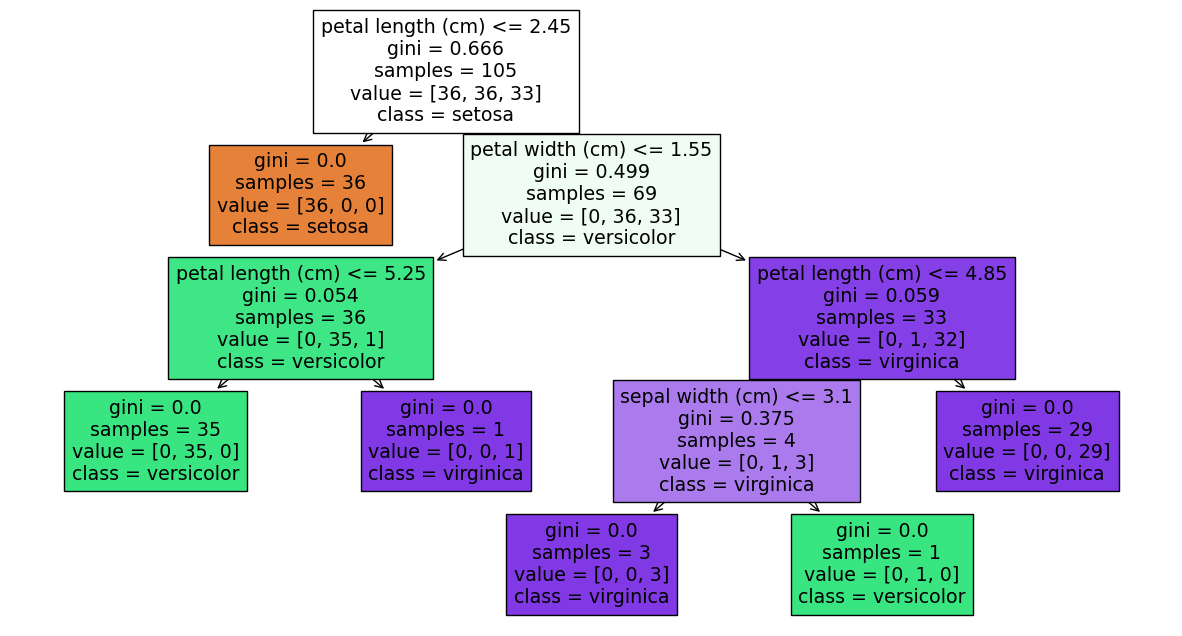

In [32]:
fig = plt.figure(figsize=(15, 8))
_ = tree.plot_tree(df_clf, 
                   feature_names=iris.feature_names,
                   class_names=list(iris.target_names),
                   filled=True)

In [33]:
pred = df_clf.predict(X_test)
ac1 = accuracy_score(y_test, pred)

In [34]:
print(ac1)

0.9111111111111111
